In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(sns.__version__)
# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)
sns.set(style="whitegrid", font_scale=2.5)

seed = 1823492

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.12.2


# corona

<div class="alert alert-block alert-info">
<h2> Clustering of outliers </h2>
</div>

In [7]:
CORONA_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/similarity_matrix/"
INTERIM_PATH = "/m/cs/work/luongn1/digirhythm/data/interim/corona/"
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/"

study = "corona"
with open(f"../config/features.txt") as f:
    features = json.load(f)

freq = "4epochs"
FEATURES = features[study][freq]

similarity_baseline_si = pd.read_csv(
    CORONA_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)

similarity_baseline_si.index = similarity_baseline_si.index.astype("str")

# All behaviour
behaviour_df = pd.read_csv(PROCESSED_PATH + f"vector_{study}_{freq}.csv", index_col=0)

# Baseline behaviour
baseline_df = pd.read_csv(
    INTERIM_PATH + f"all_participants/{freq}_si_baseline.csv", index_col=0
)
behaviour_df

,index_x,subject_id,date,heart_rate_avg,beat_to_beat_avg,heart_rate_variability_avg,breathing_rate_avg,nightly_recharge_status,ans_charge,ans_charge_status,...,stepsx1000:total:norm,steps:total:norm,index_y,tst,midsleep,bedtime,waketime,total_interruption_duration,tst:norm,midsleep:norm
0,82,2123461352,2021-06-22,56,1056,39.0,15.2,1.0,-2.6,NaN,...,0.125396,0.125396,61,6.50,27.23,23.98,30.66,660,0.344045,0.533632
1,83,3671581472,2021-06-23,63,949,43.0,13.8,5.0,1.6,NaN,...,0.355529,0.355529,83,6.86,28.01,24.58,32.34,3240,0.624031,0.308357
2,84,3609986162,2021-06-23,52,1145,98.0,10.8,5.0,8.0,NaN,...,0.505332,0.505332,84,6.76,25.72,22.34,29.58,1710,0.502868,0.496760
3,85,2123461352,2021-06-23,55,1079,61.0,15.6,5.0,1.1,NaN,...,0.077122,0.077122,85,7.93,26.50,22.54,30.64,630,0.614367,0.206278
4,86,3671581472,2021-06-24,60,994,43.0,13.2,5.0,6.3,NaN,...,0.524269,0.524269,86,6.07,28.58,25.55,32.42,2880,0.470930,0.390490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27162,30362,943412086,2022-07-04,75,800,41.0,13.2,3.0,-3.7,2.0,...,0.713109,0.713109,18257,8.46,27.68,23.45,32.60,2490,0.572581,0.746622
27163,30363,91109228,2022-07-04,57,1046,57.0,14.6,1.0,-7.0,1.0,...,0.207454,0.207454,18258,6.39,28.28,25.09,32.25,2760,0.414673,0.335832
27164,30364,2038129448,2022-07-04,52,1150,76.0,12.9,6.0,10.0,5.0,...,0.307895,0.307895,18259,8.29,29.76,25.61,34.42,1860,0.596330,0.523026
27165,30365,894567464,2022-07-03,58,1034,52.0,14.3,2.0,-6.5,1.0,...,0.522049,0.522049,18260,7.34,28.39,24.72,32.63,2040,0.646077,0.675532


In [8]:
# Outliers - Days deviating the most from baseline
def outliers(similarity, thres=1.85):
    # Calculate mean and standard deviation
    mean = similarity.mean()
    std_dev = similarity.std()

    # Calculate the lower threshold
    lower_threshold = mean - thres * std_dev

    # Find indexes of outliers
    outliers = similarity[similarity <= lower_threshold].index

    return outliers


behaviour_df

,index_x,subject_id,date,heart_rate_avg,beat_to_beat_avg,heart_rate_variability_avg,breathing_rate_avg,nightly_recharge_status,ans_charge,ans_charge_status,...,stepsx1000:total:norm,steps:total:norm,index_y,tst,midsleep,bedtime,waketime,total_interruption_duration,tst:norm,midsleep:norm
0,82,2123461352,2021-06-22,56,1056,39.0,15.2,1.0,-2.6,NaN,...,0.125396,0.125396,61,6.50,27.23,23.98,30.66,660,0.344045,0.533632
1,83,3671581472,2021-06-23,63,949,43.0,13.8,5.0,1.6,NaN,...,0.355529,0.355529,83,6.86,28.01,24.58,32.34,3240,0.624031,0.308357
2,84,3609986162,2021-06-23,52,1145,98.0,10.8,5.0,8.0,NaN,...,0.505332,0.505332,84,6.76,25.72,22.34,29.58,1710,0.502868,0.496760
3,85,2123461352,2021-06-23,55,1079,61.0,15.6,5.0,1.1,NaN,...,0.077122,0.077122,85,7.93,26.50,22.54,30.64,630,0.614367,0.206278
4,86,3671581472,2021-06-24,60,994,43.0,13.2,5.0,6.3,NaN,...,0.524269,0.524269,86,6.07,28.58,25.55,32.42,2880,0.470930,0.390490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27162,30362,943412086,2022-07-04,75,800,41.0,13.2,3.0,-3.7,2.0,...,0.713109,0.713109,18257,8.46,27.68,23.45,32.60,2490,0.572581,0.746622
27163,30363,91109228,2022-07-04,57,1046,57.0,14.6,1.0,-7.0,1.0,...,0.207454,0.207454,18258,6.39,28.28,25.09,32.25,2760,0.414673,0.335832
27164,30364,2038129448,2022-07-04,52,1150,76.0,12.9,6.0,10.0,5.0,...,0.307895,0.307895,18259,8.29,29.76,25.61,34.42,1860,0.596330,0.523026
27165,30365,894567464,2022-07-03,58,1034,52.0,14.3,2.0,-6.5,1.0,...,0.522049,0.522049,18260,7.34,28.39,24.72,32.63,2040,0.646077,0.675532


In [9]:
# Convert to vector of difference from the means

mean_diff = pd.DataFrame()

for uid in similarity_baseline_si.index.unique():
    s_si = similarity_baseline_si.loc[uid].dropna()
    outliers_indices = outliers(s_si)

    outliers_behav = (
        behaviour_df[behaviour_df.subject_id == int(uid)]
        .reset_index()
        .iloc[outliers_indices]
    )
    sample_baseline = baseline_df[baseline_df.index == int(uid)]

    diff_df = outliers_behav[FEATURES] - sample_baseline[FEATURES].values

    mean_diff = pd.concat([mean_diff, diff_df])

mean_diff.dropna(inplace=True)
mean_diff

,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm
51,0.083090,-0.104097,0.000117,-0.386300,-0.297658,0.683841,0.013233,-0.204997
65,-0.059767,-0.107805,-0.000006,-0.352281,-0.328851,0.681137,-0.024575,-0.196028
72,0.062682,-0.088901,-0.000006,-0.395249,-0.328145,0.723399,0.018904,-0.182575
86,0.297376,-0.081949,-0.000006,-0.408543,-0.303955,0.712503,-0.041588,-0.182575
93,0.205539,-0.100622,-0.000006,-0.367970,-0.324292,0.692268,-0.011342,-0.128764
...,...,...,...,...,...,...,...,...
116,0.073593,-0.072610,-0.002457,0.848629,-0.282007,-0.564165,0.006835,-0.050760
194,0.043290,-0.163720,-0.005174,0.767048,-0.244351,-0.517523,-0.548189,0.255087
207,0.088745,-0.266367,0.448911,0.494279,-0.369984,-0.573207,0.136022,-0.148212
97,-0.094156,0.156980,-0.027500,-0.200323,-0.277536,0.505358,-0.109890,0.036152


In [10]:
from sklearn.metrics import silhouette_score

# Determine optimal cluster number with elbow method
wcss = []

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(
        n_clusters=i,
        init="k-means++",  # Initialization method for kmeans
        max_iter=300,  # Maximum number of iterations
        n_init=10,  # Choose how often algorithm will run with different centroid
        random_state=0,
    )  # Choose random state for reproducibility
    labels = model.fit_predict(mean_diff)

    # Silhouette Index
    silhouette_avg = silhouette_score(mean_diff, labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal cluster number using maximum Silhouette score and maximum Dunn index
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal num cluster: ", optimal_clusters_silhouette)

Optimal num cluster:  6


In [11]:
kmeans = KMeans(
    n_clusters=optimal_clusters_silhouette,  # Set amount of clusters
    init="k-means++",  # Initialization method for kmeans
    max_iter=300,  # Maximum number of iterations
    n_init=10,  # Choose how often algorithm will run with different centroid
    random_state=seed,
)  # Choose random state for reproducibility

pred_y = kmeans.fit_predict(mean_diff[FEATURES])

mean_diff["cluster"] = kmeans.labels_ + 1
mean_diff.groupby("cluster").mean()

# Denote

# Daily clusters
# 0: Night-active individuals with less day activity and later sleep midpoint.
# 1: Morning-active individuals with earlier sleep times.
# 2: Afternoon-active individuals with higher overall activity and variability.
# 3:Evening-active individuals with increased HRV

# Weekly clusters - Pattern
# 0:
# 1: Significantly reduce steps count, increased hrv

,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm
cluster,,,,,,,,
1,0.585447,0.086018,-0.000493,-0.025881,0.013186,0.013188,-0.012862,0.052047
2,-0.177653,0.063252,0.124716,-0.111575,0.055006,-0.068146,-0.272281,0.536545
3,0.034851,-0.010724,0.001833,-0.178488,-0.319353,0.496009,0.024633,0.100110
4,-0.064759,-0.287956,0.798346,-0.125100,-0.442392,-0.230854,-0.062495,0.123518
5,-0.076611,0.098047,0.002646,-0.003144,0.135796,-0.135298,0.048198,-0.024691
6,-0.015536,-0.247094,0.021314,0.660824,-0.406670,-0.275468,0.004380,-0.027056


 Explained vairance:  [0.30828157 0.17775469 0.1592418  0.11295642]
Loading: 
                                       PC1       PC2       PC3       PC4
heart_rate_variability_avg:norm -0.118435 -0.086006 -0.768263 -0.579399
stepsx1000:total:norm           -0.318830  0.241120 -0.158525  0.479077
steps:night:norm                 0.034776 -0.064951  0.374505 -0.475678
steps:morning:norm               0.729921  0.007971 -0.195279  0.225575
steps:afternoon:norm            -0.305285  0.706791 -0.110981 -0.010117
steps:evening:norm              -0.459413 -0.649811 -0.068245  0.260220
tst:norm                        -0.016704  0.010345 -0.215661  0.153774
midsleep:norm                   -0.213982  0.090922  0.377850 -0.257224


Text(0.5, 0, 'PCA2')

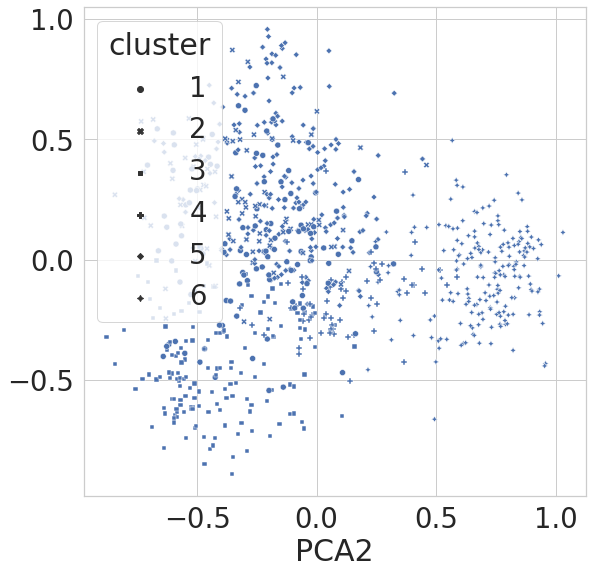

In [12]:
# PCA on meandiff
pca = PCA(n_components=4, svd_solver="full")
X = mean_diff[FEATURES]
X_pca = pca.fit_transform(X)
# X_pca['cluster'] = mean_diff['cluster']
print(" Explained vairance: ", pca.explained_variance_ratio_)


# Loading
loadings = pd.DataFrame(
    pca.components_.T, columns=["PC1", "PC2", "PC3", "PC4"], index=FEATURES
)
print("Loading: \n", loadings)

# Viz

plt.figure(figsize=(9, 9))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], style=mean_diff["cluster"])
plt.xlabel("PCA1")
plt.xlabel("PCA2")

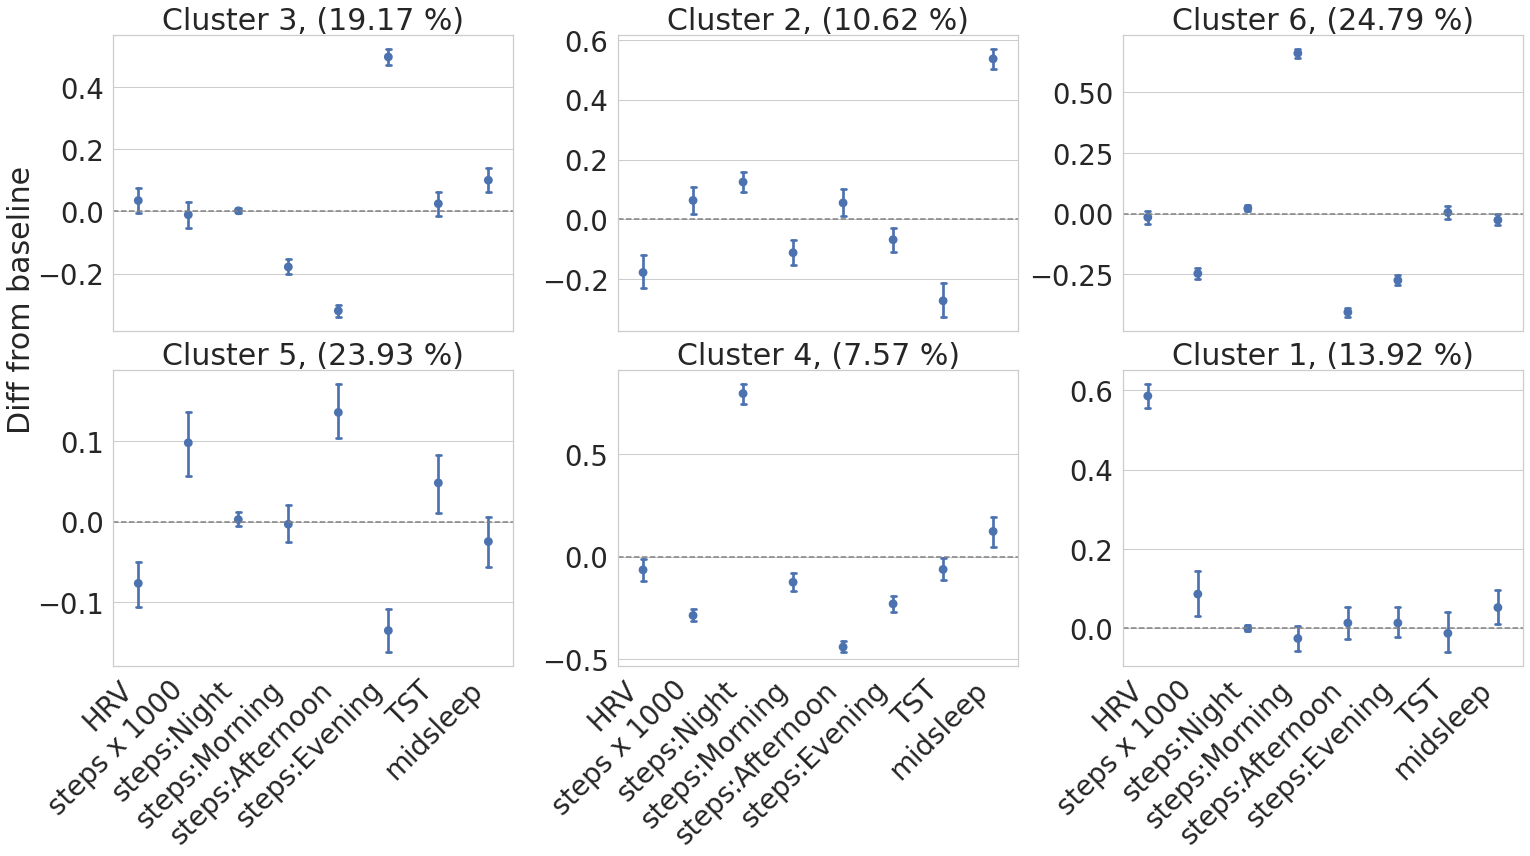

In [13]:
mean_diff.cluster.value_counts()
pivot_mean_diff = pd.melt(mean_diff, id_vars="cluster", value_vars=FEATURES)
pivot_mean_diff["label"] = pivot_mean_diff["variable"].map(
    {
        "heart_rate_variability_avg:norm": "HRV",
        "stepsx1000:total:norm": "steps x 1000",
        "steps:night:norm": "steps:Night",
        "steps:morning:norm": "steps:Morning",
        "steps:afternoon:norm": "steps:Afternoon",
        "steps:evening:norm": "steps:Evening",
        "tst:norm": "TST",
        "midsleep:norm": "midsleep",
    }
)

# Get unique clusters
clusters = pivot_mean_diff["cluster"].unique()

# Set up the matplotlib figure with 2 columns and 3 rows, sharing x-axis
fig, axes = plt.subplots(2, 3, figsize=(21, 12), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through clusters and create a point plot for each
for i, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = pivot_mean_diff[pivot_mean_diff["cluster"] == cluster]

    # Create pointplot
    sns.pointplot(
        x="label", y="value", data=cluster_data, capsize=0.1, join=False, ax=axes[i]
    )

    # Add horizontal line at y=0
    axes[i].axhline(0, color="gray", linestyle="--")

    # Set the title to the current cluster
    axes[i].set_title(
        f"Cluster {cluster}, ({np.round(len(cluster_data) / len(pivot_mean_diff) * 100, 2)} %)"
    )

    # Remove the y-axis label
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Improve readability for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

# Set a common x-axis label
fig.text(0.0, 0.5, "Diff from baseline", ha="center", rotation=90, size=30)

# Hide any unused subplots if the number of clusters is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
fig.savefig("cluster_outliers.png", dpi=300, bbox_inches="tight")
plt.show()

# MOMO

<div class="alert alert-block alert-info">
<h2> Clustering of outliers </h2>
</div>

In [17]:
MOMO_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/similarity_matrix/"
INTERIM_PATH = "/m/cs/work/luongn1/digirhythm/data/interim/momo/"
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/"

study = "momo"
with open(f"../config/features.txt") as f:
    features = json.load(f)

freq = "4epochs"
FEATURES = features[study][freq]

similarity_baseline_si = pd.read_csv(
    MOMO_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)

similarity_baseline_si.index = similarity_baseline_si.index.astype("str")

# All behaviour
behaviour_df = pd.read_csv(PROCESSED_PATH + f"vector_{study}_{freq}.csv", index_col=0)

# Baseline behaviour
baseline_df = pd.read_csv(
    INTERIM_PATH + f"all_participants/{freq}_si_baseline.csv", index_col=0
)
behaviour_df

,device_x,user,location:dist_total,location:n_bins,location:speed_average,location:speed_variance,location:speed_max,location:variance,location:log_variance,location:n_sps,...,call:outgoing_count:afternoon:norm.1,call:outgoing_count:evening:norm.1,call:outgoing_duration_total:night:norm.1,call:outgoing_duration_total:morning:norm.1,call:outgoing_duration_total:afternoon:norm.1,call:outgoing_duration_total:evening:norm.1,call:incoming_count:total:norm,call:outgoing_count:total:norm,call:incoming_duration_total:total:norm,call:outgoing_duration_total:total:norm
0,Htf4nvmhe_td,-N2FwY4uC3d7,66223.830604,130.0,3.113769,49.546299,28.520000,1.058199e-02,-4.548602,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Htf4nvmhe_td,-N2FwY4uC3d7,189353.851690,133.0,2.459399,52.129126,31.065000,1.512700e-01,-1.888689,1.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.285714,0.000000,0.365261,0.000000
2,Htf4nvmhe_td,-N2FwY4uC3d7,25790.968582,126.0,0.865238,11.849312,26.860001,1.313992e-03,-6.634685,2.0,...,0.000000,0.000000,0.0,0.003191,0.000000,0.000000,0.142857,0.076923,0.004497,0.001548
3,Htf4nvmhe_td,-N2FwY4uC3d7,38335.657421,99.0,1.491768,14.995781,19.600000,1.628054e-03,-6.420370,2.0,...,0.111111,0.111111,0.0,0.000000,0.012752,0.025018,0.000000,0.153846,0.000000,0.033945
4,Htf4nvmhe_td,-N2FwY4uC3d7,23980.867449,120.0,1.477958,14.634319,24.330000,2.798196e-04,-8.181366,2.0,...,0.111111,0.000000,0.0,0.000000,0.048385,0.000000,0.000000,0.076923,0.000000,0.048356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,50s-St2nTE6D,zVn4Ri3rADQI,35600.023248,78.0,2.637561,31.919460,30.161777,1.020209e-03,-6.887747,1.0,...,0.000000,0.250000,0.0,0.000000,0.000000,0.001153,0.142857,0.142857,0.486156,0.000849
23140,50s-St2nTE6D,zVn4Ri3rADQI,14175.059051,75.0,1.770682,17.101914,25.421537,2.531271e-05,-10.584204,1.0,...,1.000000,0.000000,0.0,0.000000,0.138129,0.000000,0.571429,0.428571,0.037278,0.138129
23141,50s-St2nTE6D,zVn4Ri3rADQI,21528.278636,112.0,1.500980,17.321359,30.000904,1.287605e-04,-8.957556,1.0,...,0.333333,0.000000,0.0,0.043943,0.053257,0.000000,0.285714,0.285714,0.221500,0.061108
23142,50s-St2nTE6D,zVn4Ri3rADQI,12631.783377,79.0,1.696906,12.707052,24.209200,1.445678e-05,-11.144347,1.0,...,0.333333,0.250000,0.0,1.000000,0.000849,1.000000,0.571429,0.571429,0.089095,0.915765


In [19]:
# Convert to vector of difference from the means

mean_diff = pd.DataFrame()

for uid in similarity_baseline_si.index.unique():
    s_si = similarity_baseline_si.loc[uid].dropna()
    outliers_indices = outliers(s_si)

    outliers_behav = (
        behaviour_df[behaviour_df.user == uid].reset_index().iloc[outliers_indices]
    )
    sample_baseline = baseline_df[baseline_df.index == uid]

    diff_df = outliers_behav[FEATURES] - sample_baseline[FEATURES].values

    mean_diff = pd.concat([mean_diff, diff_df])

mean_diff.dropna(inplace=True)
mean_diff

,location:n_sps:norm,location:entropy:norm,location:log_variance:norm,location:proportion_home,application:count:comm:night:norm,application:count:comm:morning:norm,application:count:comm:afternoon:norm,application:count:comm:evening:norm,application:duration:comm:total:norm
11,0.285714,0.000000,0.055501,0.066170,0.000000,0.004808,0.051352,-0.056160,-0.061526
107,-0.047619,0.000000,0.195190,-0.012421,0.000000,0.072837,0.104521,-0.177358,-0.060030
110,0.285714,0.000000,0.076704,0.020210,0.000000,0.093296,0.101319,-0.194615,0.048101
115,0.285714,0.000000,0.284848,0.048224,0.037736,0.112899,0.090047,-0.240682,-0.038360
126,0.619048,0.903594,0.011333,0.020912,0.000000,0.233260,-0.120630,-0.112630,0.121832
...,...,...,...,...,...,...,...,...,...
59,0.035714,0.000000,0.182322,-0.006617,0.000000,-0.075325,0.005666,0.069658,0.077946
109,0.035714,0.000000,-0.320917,0.006541,0.000000,-0.054446,0.027644,0.026801,0.027481
110,0.035714,0.000000,0.203845,-0.009068,0.000000,0.053247,0.159952,-0.213199,0.083255
118,0.035714,0.000000,-0.315588,0.059312,0.000000,0.021539,-0.036145,0.014606,0.034505


In [20]:
from sklearn.metrics import silhouette_score

# Determine optimal cluster number with elbow method
wcss = []

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(
        n_clusters=i,
        init="k-means++",  # Initialization method for kmeans
        max_iter=300,  # Maximum number of iterations
        n_init=10,  # Choose how often algorithm will run with different centroid
        random_state=0,
    )  # Choose random state for reproducibility
    labels = model.fit_predict(mean_diff)

    # Silhouette Index
    silhouette_avg = silhouette_score(mean_diff, labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal cluster number using maximum Silhouette score and maximum Dunn index
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal num cluster: ", optimal_clusters_silhouette)

Optimal num cluster:  2


In [21]:
kmeans = KMeans(
    n_clusters=optimal_clusters_silhouette,  # Set amount of clusters
    init="k-means++",  # Initialization method for kmeans
    max_iter=300,  # Maximum number of iterations
    n_init=10,  # Choose how often algorithm will run with different centroid
    random_state=seed,
)  # Choose random state for reproducibility

pred_y = kmeans.fit_predict(mean_diff[FEATURES])

mean_diff["cluster"] = kmeans.labels_ + 1
mean_diff.groupby("cluster").mean()

# Denote

# Daily clusters
# 0: Night-active individuals with less day activity and later sleep midpoint.
# 1: Morning-active individuals with earlier sleep times.
# 2: Afternoon-active individuals with higher overall activity and variability.
# 3:Evening-active individuals with increased HRV

# Weekly clusters - Pattern
# 0:
# 1: Significantly reduce steps count, increased hrv

,location:n_sps:norm,location:entropy:norm,location:log_variance:norm,location:proportion_home,application:count:comm:night:norm,application:count:comm:morning:norm,application:count:comm:afternoon:norm,application:count:comm:evening:norm,application:duration:comm:total:norm
cluster,,,,,,,,,
1,0.421703,0.562343,0.268536,-0.118657,-0.009606,0.010420,0.051282,-0.024625,0.025523
2,-0.018381,-0.064945,-0.034539,0.038631,0.005161,0.020454,0.032391,-0.008864,0.037705


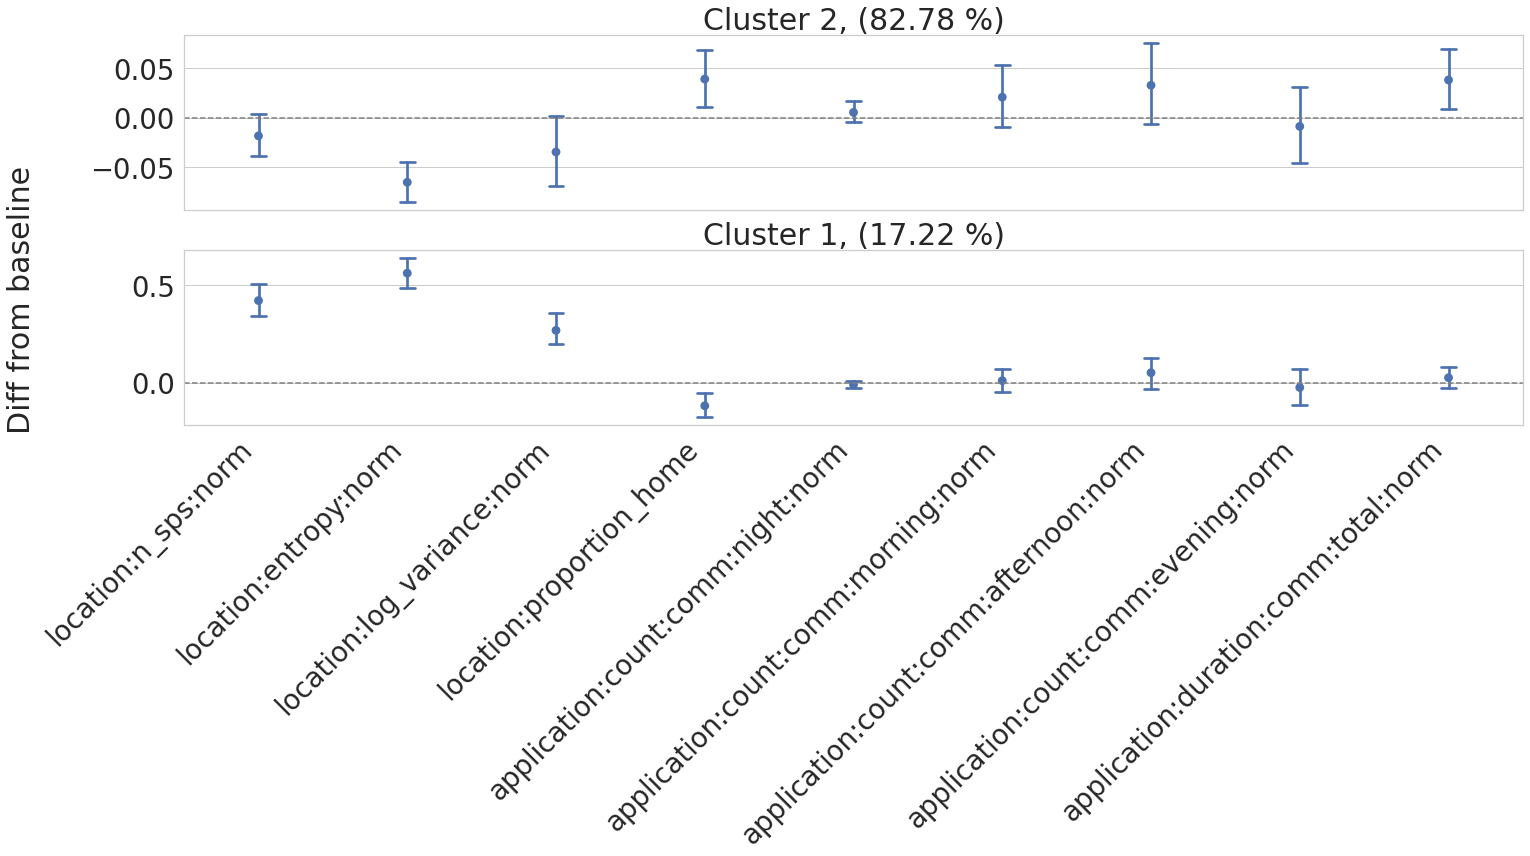

In [24]:
mean_diff.cluster.value_counts()
pivot_mean_diff = pd.melt(mean_diff, id_vars="cluster", value_vars=FEATURES)
pivot_mean_diff["label"] = pivot_mean_diff["variable"]

# Get unique clusters
clusters = pivot_mean_diff["cluster"].unique()

# Set up the matplotlib figure with 2 columns and 3 rows, sharing x-axis
fig, axes = plt.subplots(2, 1, figsize=(21, 12), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through clusters and create a point plot for each
for i, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = pivot_mean_diff[pivot_mean_diff["cluster"] == cluster]

    # Create pointplot
    sns.pointplot(
        x="variable", y="value", data=cluster_data, capsize=0.1, join=False, ax=axes[i]
    )

    # Add horizontal line at y=0
    axes[i].axhline(0, color="gray", linestyle="--")

    # Set the title to the current cluster
    axes[i].set_title(
        f"Cluster {cluster}, ({np.round(len(cluster_data) / len(pivot_mean_diff) * 100, 2)} %)"
    )

    # Remove the y-axis label
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Improve readability for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

# Set a common x-axis label
fig.text(0.0, 0.5, "Diff from baseline", ha="center", rotation=90, size=30)

# Hide any unused subplots if the number of clusters is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
fig.savefig("cluster_outliers.png", dpi=300, bbox_inches="tight")
plt.show()